In [12]:
import jieba
import jieba.analyse
import pandas as pd
import codecs
import string
import re
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from gensim import corpora, models
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']="SimHei"
plt.rcParams['axes.unicode_minus']=False
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [13]:
pd.read_csv("主谓宾关键词.csv")

OSError: Initializing from file failed

In [3]:
df = pd.read_excel("C题全部数据/附件3.xlsx")
df['留言时间']=pd.to_datetime(df['留言时间'])
df=df.sort_values(by="留言时间")
df=df.set_index("留言时间")
df['hot']=df["反对数"]+df["点赞数"]
df.sort_values("hot",ascending=False).head(5)

,留言编号,留言用户,留言主题,留言详情,反对数,点赞数,hot
留言时间,,,,,,,
2019-08-19 11:34:04,208636,A00077171,A市A5区汇金路五矿万境K9县存在一系列问题,\n\t\t\t\t\t\n\t\t\t\t\t我是A市A5区汇金路五矿万境K9县24栋的一...,0,2097,2097
2019-04-11 21:02:44,223297,A00087522,反映A市金毛湾配套入学的问题,\n\t\t\t\t\t\n\t\t\t\t\t书记先生：您好！我是梅溪湖金毛湾的一名业主，...,5,1762,1767
2019-02-21 18:45:14,220711,A00031682,请书记关注A市A4区58车贷案,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的胡书记：您好!A4区p2p公司58车贷...,0,821,821
2019-02-25 09:58:37,217032,A00056543,严惩A市58车贷特大集资诈骗案保护伞,\n\t\t\t\t\t\n\t\t\t\t\t胡市长：您好！西地省展星投资有限公司设立58...,0,790,790
2019-03-01 22:12:30,194343,A000106161,承办A市58车贷案警官应跟进关注留言,\n\t\t\t\t\t\n\t\t\t\t\t胡书记：您好！58车贷案发，引发受害人举报投...,0,733,733


## 将区县信息加入到词典

In [4]:
region=["区","县","号线"]
jieba.add_word("A市")
jieba.add_word("A市经济学院")
jieba.add_word("经济学院")
jieba.add_word("B市")
for i in range(1,10):
    word1="A"+str(i)+"区"
    word2="A"+str(i)+"县"
    word3=str(i)+"号线"
    jieba.add_word(word1)
    jieba.add_word(word2)
    jieba.add_word(word3)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lzh\AppData\Local\Temp\jieba.cache
Loading model cost 0.753 seconds.
Prefix dict has been built successfully.


## 清洗数据
   * 1、内容清洗同上题
   * 2、正则匹配出每句话发生的地点 

In [5]:
#定义删除除字母,数字，汉字以外的所有符号的函数

def clean_review(df,column_name,stopword_file):
    '''
    对数据集中的文本内容进行清洗以及分词
    df:数据集文件
    column_name:要处理的列
    stopword_file:停用词表路径
    '''
    def remove_punctuation(line):
        try:
            line = str(line)
        except:
            pass
        if line.strip()=='':
            return ''
        rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
        line = rule.sub('',line)
        return line
    #加载停用词文件
    def stopwordslist(filepath,encoding="utf-8"):  
        stopwords = [line.strip() for line in open(filepath, 'r', encoding=encoding).readlines()]  
        return stopwords  

   
    test=df[[column_name]]
    test['留言主题']=df['留言主题']
    #加载停用词
    stopwords = stopwordslist(stopword_file,encoding="GB18030")
    #删除除字母,数字，汉字以外的所有符号
    test['clean_review'] = test[column_name].apply(remove_punctuation)
    #分词，并过滤停用词
    test['cut_review'] = test['clean_review'].apply(lambda x: " ".join([w for w in list(jieba.cut(x)) if w not in stopwords]))
    return test

def get_place(line):
    '''
    正则匹配评论地点
    '''
    try:
        place=re.findall("A[0-9].|A市|[\u4e00-\u9fa5_a-zA-Z0-9_]{4}小区",line)[0]
    except:
        place="未知"
    return place

## 统计各个地区的信息

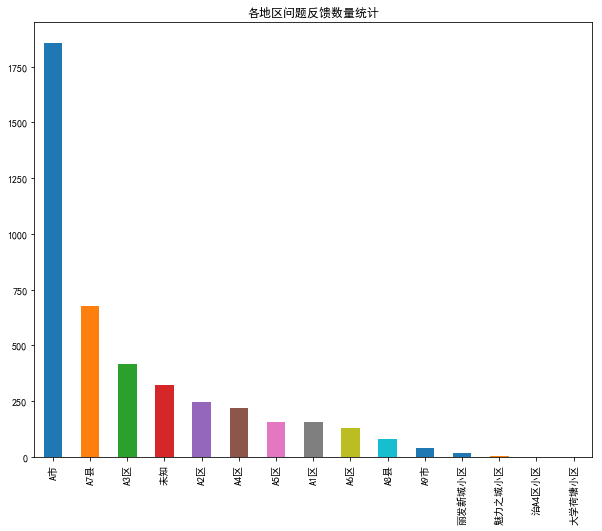

In [14]:
test=clean_review(df,"留言主题","stopword.txt")
# test2=clean_review(df,"留言详情","stopword.txt")
test["地区"]=test['留言主题'].apply(get_place).tolist()
test=test.sort_values(by="地区")
test['地区'].value_counts().plot(kind='bar',figsize=(10,8),title="各地区问题反馈数量统计")

In [15]:
from ltp_method import LtpParser

In [16]:
# import jieba.analyse
zwb=[]
review=test.clean_review
length=len(review)
ltp=LtpParser()
for i in range(length):
    print('\r{:.2f}%'.format((i+1)/length*100),end=' ')
    zwb.append(ltp.getMain(review[i]))
test['主谓宾']=zwb

100.00% 

In [17]:
key_words=[]
for src in test.cut_review:
    key_words.append(jieba.analyse.extract_tags(sentence=src,topK=5))
test['关键词']=key_words

## 实体识别

In [64]:
place=[]
for sentence in test['留言主题']:
    words, postags = ltp.parser_process(sentence)
    NER_1 = ""
    for index, tag in enumerate(postags):
        if tag == 'ns' and len(words[index]) > 1:#地名
            NER_1+=words[index]
        elif tag == 'ni' and len(words[index]) > 1: #组织名
            NER_1+=words[index]
        elif tag == 'nh' and len(words[index]) > 1:#人名
            NER_1+=words[index]
       
       
    place.append(NER_1)
test['实体']=place

In [73]:
test.to_csv("泰迪杯第二题实体识别关键词.csv",index=None,encoding='utf-8')

---
## finish  以下内容与本题无关(忽略)
---

In [6]:
def LDA_region(region_name):
    A1=test[test['地区']==region_name].copy()
    documents=A1['cut_review']

    words_ls = []
    for text in documents:
        text=text.split(" ")
        words_ls.append(text)
    # print(words_ls)
    # 生成语料词典
    dictionary = corpora.Dictionary(words_ls)
    print(dictionary)
    # 生成稀疏向量集
    corpus = [dictionary.doc2bow(words) for words in words_ls]
    # LDA模型，num_topics设置聚类数，即最终主题的数量
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=int(len(A1)/2))
    # # 展示每个主题的前5的词语
    # for topic in lda.print_topics(num_words=5):
    #     print(topic[0],":",topic[1])
    # # 推断每个语料库中的主题类别
    # print('推断：')

    topic_ids=[]
    for e, values in enumerate(lda.inference(corpus)[0]):
        topic_val = 0
        topic_id = 0
        for tid, val in enumerate(values):
            if val > topic_val:
                topic_val = val
                topic_id = tid
        topic_ids.append(topic_id)
    #     print(topic_id, '->', documents[e])

    A1['预测类别']=topic_ids
    A1=A1.sort_values(by="预测类别")
    return A1

## 对上述的每个地区聚类分析（地区名称保存在以上cell中的places列表）

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def labels_to_original(labels, forclusterlist):
    assert len(labels) == len(forclusterlist)
    maxlabel = max(labels)
    numberlabel = [i for i in range(0, maxlabel + 1, 1)]
    numberlabel.append(-1)
    result = [[] for i in range(len(numberlabel))]
    for i in range(len(labels)):
        index = numberlabel.index(labels[i])
        result[index].append(forclusterlist[i])
    return result

def cluster(df):
    '''
    1、将内容转为词向量
    2、分别选择50、100、150、200簇进行聚类
    3、如果df中的样本数不足需要聚类的簇数时，将SSE填充为999
    4.返回词向量矩阵，文本，效果最好的分类簇数
    '''
    corpus = df['cut_review'].tolist()
    
    # 该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
    vectorizer = CountVectorizer(max_features=1000)
    # 该类会统计每个词语的tf-idf权值
    tf_idf_transformer = TfidfTransformer()
    # 将文本转为词频矩阵并计算tf-idf
    tfidf = tf_idf_transformer.fit_transform(vectorizer.fit_transform(corpus))
    
    # 获取词袋模型中的所有词语
    tfidf_matrix = tfidf.toarray()
    # 获取词袋模型中的所有词语
    word = vectorizer.get_feature_names()


    X = [10,50,100,150,200]
    SSE = []  # 存放每次结果的误差平方和
    score=[]
    for n_clusters in X:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        try:  
            estimator=clusterer.fit(tfidf_matrix)
        except:
            SSE.append(999)
            continue
        SSE.append(estimator.inertia_)
        cluster_labels = clusterer.predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.plot(X,SSE,'o-')
    plt.show()
    
    
    #选择误差平方和最小的
    num=min(zip(SSE,X))[1]

    return tfidf_matrix,corpus,num

def train_kmeans(num,tfidf_matrix,corpus):
    '''
    根据cluster的结果合理选择聚类簇数num
    训练模型，可视化结果
    num:聚类簇数
    '''
    # 聚类
    clf = KMeans(n_clusters=num)
    s = clf.fit(tfidf_matrix)

    # 每个样本所属的簇
    label = []
    i = 1
    while i <= len(clf.labels_):
        label.append(clf.labels_[i - 1])
        i = i + 1
    # 获取标签聚类
    y_pred = clf.labels_
    print("长度：",len(y_pred),"簇数：",num)
    # pca降维，将数据转换成二维
    pca = PCA(n_components=2)  # 输出两维
    newData = pca.fit_transform(tfidf_matrix)  # 载入N维

    xs, ys = newData[:, 0], newData[:, 1]
    # 设置颜色
    cluster_colors = cm.rainbow(np.linspace(0, 1,num))

    # 设置类名
    cluster_names = [i for i in range(num)]

    df = pd.DataFrame(dict(x=xs, y=ys, label=y_pred, title=corpus))
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(8, 5))  # set size
    ax.margins(0.02)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=cluster_names[name],
                color=cluster_colors[name], mec='none')
    plt.show()

    res = labels_to_original(y_pred , corpus)

    count=0
    for i in range(len(res)):
        if(count==5):
            break
        for j in res[i]:
            print(j)
        print("=======================")
        count+=1
        
    return res

==================================A1区==============================
For n_clusters = 10 The average silhouette_score is : 0.023845828706780463
For n_clusters = 50 The average silhouette_score is : 0.07520422742324226
For n_clusters = 100 The average silhouette_score is : 0.08414572155653162
For n_clusters = 150 The average silhouette_score is : 0.04607204682565916


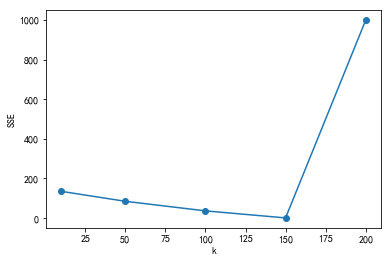

长度： 156 簇数： 150


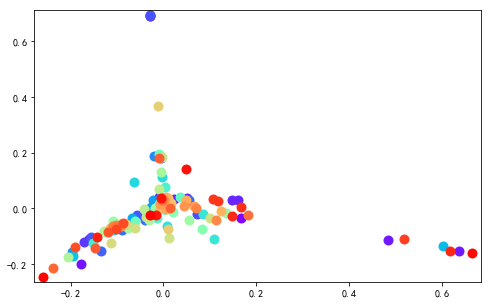

A1区 大同 瑞致 小学 违规 家校通 平台
A1区 荷 花园 街道 华城 广场 楼下 修 地铁 太 吵
A1区 桐阴里 小区 夜间 施工
A1区 A2区 华庭 物业 层楼 消防通道 门 锁住
A1区 德政 园 社区 麻将馆 噪音 扰民
==================================A2区==============================
For n_clusters = 10 The average silhouette_score is : 0.02186248748962604
For n_clusters = 50 The average silhouette_score is : 0.05536714143769774
For n_clusters = 100 The average silhouette_score is : 0.08217511156734697
For n_clusters = 150 The average silhouette_score is : 0.08901424936791687
For n_clusters = 200 The average silhouette_score is : 0.08415096958233359


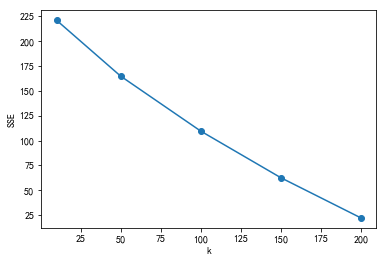

长度： 248 簇数： 200


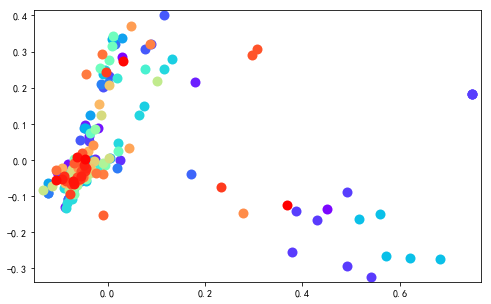

A2区 碧桂园 公园 一号 里 英派 健身房 游泳池 卫生 达标
A2区 银桂苑 小区 西侧 工地 扰民
A2区 丽发 新城 小区 太吵
A2区 天悦 幼儿园 教师 流动性 太大
A2区 暮云 街道 西湖 小区 垃圾 谁来管
A2区 暮云 街道 西湖 小区 村委会 小区 垃圾 处置
==================================A3区==============================
For n_clusters = 10 The average silhouette_score is : 0.020296775527471625
For n_clusters = 50 The average silhouette_score is : 0.046350129556423286
For n_clusters = 100 The average silhouette_score is : 0.09365880083581274
For n_clusters = 150 The average silhouette_score is : 0.11344186339395122
For n_clusters = 200 The average silhouette_score is : 0.11573254268503118


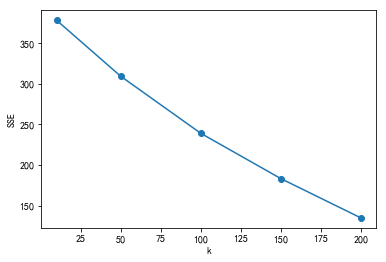

长度： 416 簇数： 200


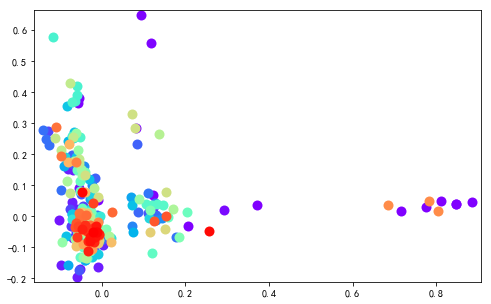

A3区 西湖 文化园 偷钓者 猖獗
A3区 西湖 街道 茶场 村 五组 启动 拆迁
A3区 西湖 街道 茶场 村 拆迁
A3区 西湖 街道 茶场 村 五组 拆迁
A3区 西湖 街道 茶场 村 五组 拆迁 村民 何去何从
A3区 西湖 街道 格林 星城 路段 人行道 常年 僵尸 车
A3区 西湖 街道 茶场 村 五组 启动 拆迁
A3区 西湖 街道 茶场 村 五组 启动 征地 拆迁
A3区 洋湖 街道 工地 施工 噪音 扰民
A3区 洋湖 街道 工地 噪音 扰民
A3区 洋湖 三期 北门 开
A3区 东方红 街道 金南 家园 三期 工地 通宵 施工
A3区 金南 家园 二期 旁边 工地 噪音 扰民
A3区 洋湖 街道 白鹭 社区 便民服务 便民
A3区 象山 国际 工地 三考 期间 凌晨 噪音 施工
A3区 麓 谷 师范 安置 小区 抽烟 机 影响 居民 生活 睡眠
A3区 望月湖 麓 山 国际 门口 奶茶 店 涉及 无证 经营 半年 久
A3区 新民 小区 住 改商 无证 经营 影响 居民 生活 污染
房子 拆 多年 A3区 西湖 街道 安置 办 安置
A3区 惟盛园 安置 小区 不合理 收费
A3区 A3区 街道 惟盛园 安置 小区 收费 不合理
A3区 惟盛园 小区 网络 垄断
A3区 A3区 街道 安置 小区 惟盛园 业主 房子
A3区 建工 象山 国际 楼盘 开工 深夜 凌晨 四五点
A3区 建工 象山 国际 楼盘 开工 深夜 凌晨
==================================A4区==============================
For n_clusters = 10 The average silhouette_score is : 0.021987679383119626
For n_clusters = 50 The average silhouette_score is : 0.06594870893349025
For n_clusters = 100 The average silhouette_score is : 0.08884441488899766
For n_clusters = 150 The average silhouette_score is : 0.08732093777074745
Fo

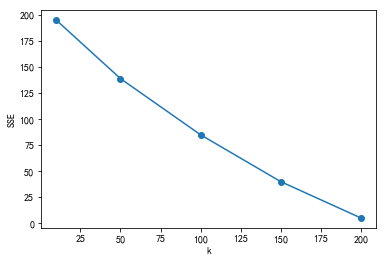

长度： 219 簇数： 200


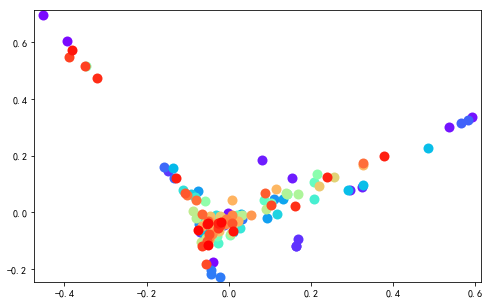

A4区 A4区 寺 围墙 摆放 报废 共享 单车 影响 市容
A4区 东兴 园 街道 富雅坪 小区 消防通道 常年 私家车 占用
A4区 洪山 公园 建设 计划 正式 启动
请 解决 A4区 凯乐 国际 城 周边 太平路 路灯
A4区 凯乐 国际 城 周边 庆 里 路 太平路 路灯 很久没 亮
A4区 波隆 立交桥 小区 居民 不堪 噪音 污染
==================================A5区==============================
For n_clusters = 10 The average silhouette_score is : 0.034599325668638964
For n_clusters = 50 The average silhouette_score is : 0.08685982650963796
For n_clusters = 100 The average silhouette_score is : 0.10341420977005165
For n_clusters = 150 The average silhouette_score is : 0.08440209647796522


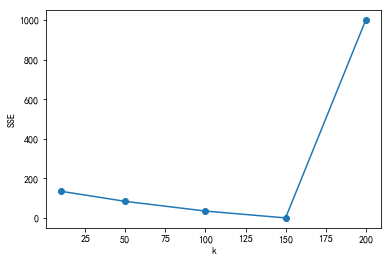

长度： 157 簇数： 150


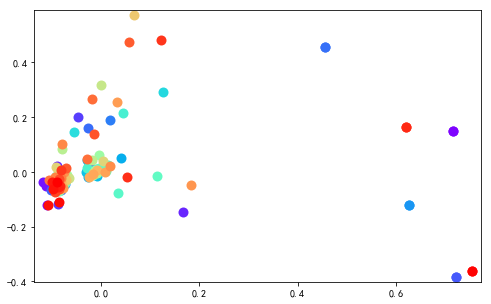

A5区 迎 新路 中意 路至 万芙路 路段 单向 通行 隔离 优化 措施
A5区 劳动 东路 魅力 城 小区 油烟 扰民
A5区 劳动 东路 魅力 城 小区 油烟 扰民
咨询 A5区 洞井镇 鄱阳 村 三期 安置 房
A5区 A5区 亭 办事处 自然村 村民 房屋 安全隐患
A5区 井 湾子 街道 木莲 中路 曙光 南路 交叉口 周边环境 改善 建议
A5区 井 湾子 木莲 中路 曙光 南路 周边环境 改善 建议
==================================A6区==============================
For n_clusters = 10 The average silhouette_score is : 0.03077987349044273
For n_clusters = 50 The average silhouette_score is : 0.09515670248366623
For n_clusters = 100 The average silhouette_score is : 0.097228127135494


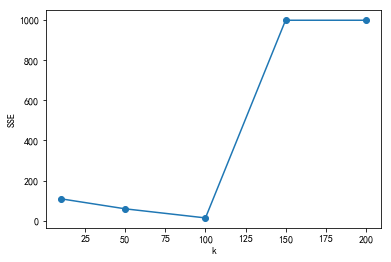

长度： 129 簇数： 100


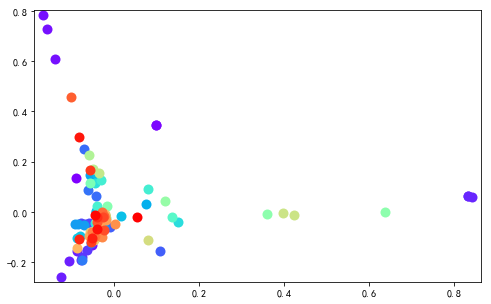

请求 协调 A6区 康乃馨 医院 解决 收费 纠纷
投诉 A6区 润 紫 郡 私自 小区 外 墙上 安装 油烟 管道
投诉 A6区 润 紫 郡 私自 小区 外 墙上 安装 油烟 管道
四问 A6区 景城苑 何时能 解决
三问 A6区 景城苑 小区 何时能 解决
问 A6区 景城苑 小区 何时能 解决
A6区 金桥 国际 公园 里 项目 夜间 通宵 施工 扰民 间断
咨询 A6区 丁字湾 街道 未来 发展 规划 相关
咨询 A6区 丁字湾 相关 规划 发展 计划
咨询 A6区 高新区 未来 规划
==================================A7县==============================
For n_clusters = 10 The average silhouette_score is : 0.01943341962807578
For n_clusters = 50 The average silhouette_score is : 0.05593198431035656
For n_clusters = 100 The average silhouette_score is : 0.08507836839684811
For n_clusters = 150 The average silhouette_score is : 0.1230314403237959
For n_clusters = 200 The average silhouette_score is : 0.14718692233288969


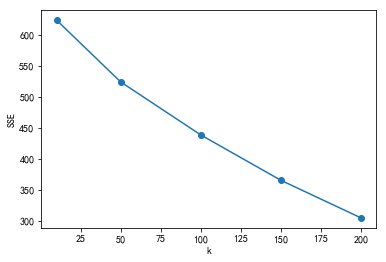

长度： 678 簇数： 200


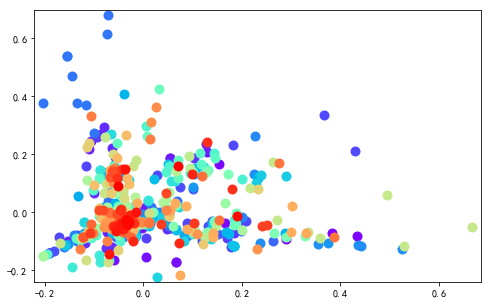

A7县 果园镇 果 覆车 业 废水 未作 直排 我家 鱼塘
A7县 果园镇 浔 龙河 村 养猪场 污水 横流 臭气熏天
A7县 城 K4 县置 小区 夜宵 店 噪音 油烟 扰民
A7县 城东 小区 宵夜 店 噪音 油烟 扰民
请 A7县 领导 重视 松雅 安置 小区 夜宵 店 扰民
A7县 康桥 长郡 二栋 楼下 烧烤店 油烟 污染 噪音 扰民
A7县 榔 梨 综合 市场 A4 栋 烤肉店 油烟 扰民
A7县 新 长海 车库 漏水 停止
呼吁 停止 A7县 泉塘 街道 小塘路 设置 110kv 变电站
A7县 小塘路 修
盼查 A7县 外卖 商家 食品卫生
A7县 楚龙动岚 健身 承诺 返现 说 说
A7县 公安干警 利用 职务 查询 行踪
A7县 双江 镇 田土 补助
冰雪 天气 A7县 校车 停运
A7县 妇幼医院 儿童 常见病 接诊
A7县 金茂路 拓改白 改黑
A7县 改 区
A7县 金贸路 拓宽 并白 改黑
A7县 海德公园 楼盘 配套 公办 幼儿园 普惠性 幼儿园
A7县 恒基 凯旋门 小区 配套 幼儿园 公办 普惠
A7县 恒基 凯旋门 小区 配套 幼儿园 公办 普惠
A7县 松雅 安置 区 配套 公办 幼儿园
==================================A8县==============================
For n_clusters = 10 The average silhouette_score is : 0.04343607857916529
For n_clusters = 50 The average silhouette_score is : 0.08691355593271263


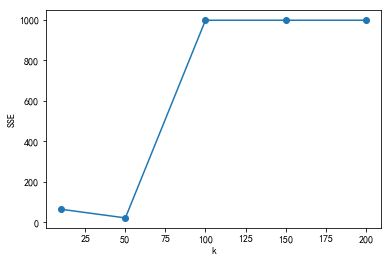

长度： 80 簇数： 50


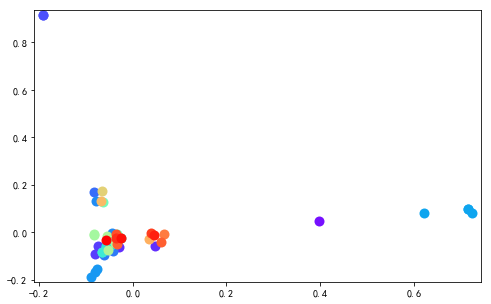

A8县 延瑞 汽车 饰件 公司 新建 厂房 安全隐患
A8县 市名 项目 福建 吴珩 建筑 公司 拖欠 33 位 农民工 血汗钱
A8县 市 美的 城 精装 房 质量
投诉 A8县 肢体 残疾人 婚前 财产 妻子 侵占 卷 走 51 万 一案
A8县 市 水木 天成 朝庭 小区 用电 求 解决
A8县 市 水木 天成 临时 电线 布满 安全隐患
投诉 A8县 市中梁 首府 开发商 偷工减料
A8县 市 东方 城 业主 没拿到 房产证
A8县 市 喜盈门 范程 商铺 合同 违约 请求 主持公道
A8县 市中梁 首府 业主 请求 维权
==================================A9市==============================
For n_clusters = 10 The average silhouette_score is : 0.058286786362104374


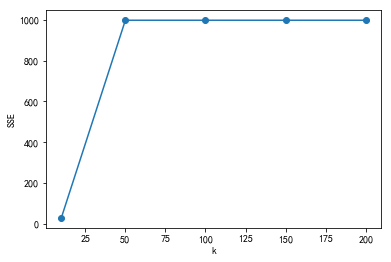

长度： 41 簇数： 10


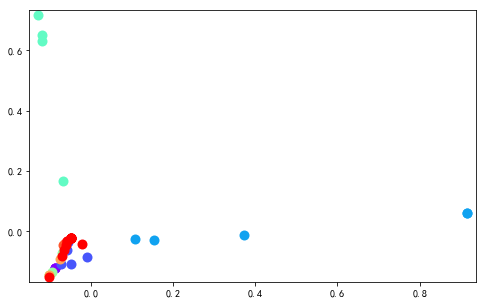

建议 渝 长厦 A9 市站 选择 A9 市 西南角 设 站
A9 市 城区 南 西 片区 城铁 站 设立 建议
A9 市到 A市 319 路 太烂 建议 修
A9 市 龚家桥 小区 楼下 夜宵 店 扰民
举报 A9 市 四季 花城 小区业主 委员会 选聘 小区 物业公司 过程 中 暗箱 操作
A9 市 碧桂园 城市 花园 小区 旁 违规 建 垃圾站
A9 市 关口 街道 办事处 长兴 社区 四季 花城 业主 委员会 筹建 过程 中 涉嫌 违规
A9 市古港 镇 宝盖 村 土地 占 无证 建房 经营 举报 三年 未 解决
A9 市 居民区 小学 旁 医院 三馆 中心 建 垃圾站
A9 市禧 路 垃圾 分拣 中心 符合 恳请 拆除
A9 市禧 路 垃圾 分拣 中心 符合 恳请 拆除
A9 市 城市 建设 集团 未经 业主 同意 公共 区域 建设 垃圾 分拣 中心
A9 市淮川 街道 税务 中心 机构 解散 人员 分流 面临 失业
A9 市集 里 街道办 唐 家园 村 新桥 组 液化 汽 检测 厂 排放 废气
中铁 十五 局一 公司 A9 市蒙华 铁路 工程 拖欠 工程款
请 落实 潜江 韶关 输气管道 A9 市段 农田 临时 租赁 恢复 工作
蒙华 铁路 A9 市段 一季度 工程款 未 拨付
蒙华 铁路 A9 市段 中铁 十五 局二 工区 施工队 拖欠 农民工 工资
==================================A市==============================
For n_clusters = 10 The average silhouette_score is : 0.023435079459196338
For n_clusters = 50 The average silhouette_score is : 0.053657768112423655
For n_clusters = 100 The average silhouette_score is : 0.07804957078426301
For n_clusters = 150 The average silhouette_score is : 0.09553068550501738
For n_clusters = 200 The average silhouett

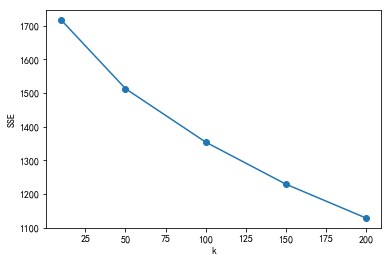

长度： 1858 簇数： 200


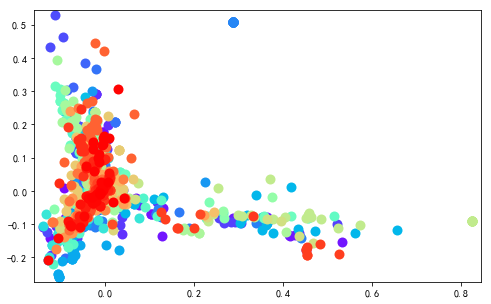

A市 经开区 城北 污水 厂内 项目 消防栓 布局 不合理
A市 新华联 涉嫌 虚假 广告 欺诈 销售
A市 晟 福兴 金城 二期 涉嫌 虚假 宣传
投诉 A市 绿地 城际 空间站 虚假 宣传
A市 高岭 商贸城 销售 商铺 时 涉嫌 虚假 宣传 市场 冷清
A市 晟 福兴 金城 二期 涉嫌 虚假 宣传
A市 恒大 江湾 二期 虚假 宣传 制定 合同 霸王 条款
A市 地方 美食 虚假 招商 涉嫌 金额
A市 自梦强 数码科技 公司 虚假 宣传 退货
A市 鑫苑 木莲 世家 涉嫌 虚假 宣传 偷工减料
投诉 A市 鑫苑 木莲 世家 涉嫌 虚假 宣传
投诉 A市 晟 福兴 金城 二期 涉嫌 虚假 宣传
A市 晟 福兴 金城 二期 涉嫌 虚假 宣传
举报 A市 自梦强 数码科技 有限公司 虚假 宣传
A市 自梦强 数码科技 有限公司 虚假 宣传 误导 消费者
A市 A3区 洺 悦城 虚假 宣传
投诉 A市 保利 汇 虚假 宣传
A市 矿五 地产 开发 公司 虚假 宣传 欺骗 消费者
A市 保利 汇 开发商 虚假 宣传 修改 规划
请求 开通 E7 县至 A市 深圳 高铁 班次
A市 快速 公交 万家 丽线 何时能 开通 运行
C 市到 A市 开通 地铁
A市 开通 地铁 环线
请问 A市 地铁 3号线 开通
A市 A3区 含浦镇 含浦 街道 芝字 港村 开通 公交车
开通 A市 B市 cun 公交车
希望 A市 地铁 1号线 涂家 冲站 号 出口 建设 开通
B市 A市 开通 地铁 规划
A市 环城 绿带 节点 建设 规划 实施
A市 梅 溪湖 梅岭 国际 二期 违规 变更 规划 拖延 建设
A市 梅岭 国际 规划 变 迟迟 不建
A市 梅岭 国际 规划 变 迟迟 不建
A市 梅 溪湖 梅岭 国际 配套 幼儿园 拖延
投诉 A市 惠 天然 梅岭 国际 开发商 违规 收取 万元 服务费
黑心 搅拌 厂建 A市 丽发 新城 小区
A市 A2区 丽发 新城 小区 搅拌站 明目张胆 污染环境
A市 丽发 新城 违建 搅拌站 施工 扰民 污染环境
A市 万家 丽 南路 丽发 新城 居民区 搅拌站 扰民
A市 A2区 丽发 新城 小区 遭 搅拌站 污染
我要 举报 A市 A2区 丽发 新城 小区 开发商 违规 建设 搅拌站
A市 丽发 新城 小区 搅拌站 噪音 扰民 污染环境
A市

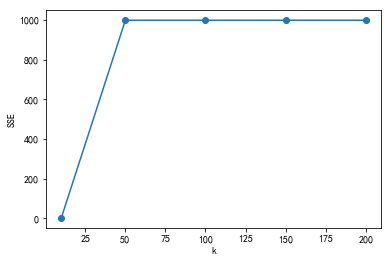

长度： 16 簇数： 10


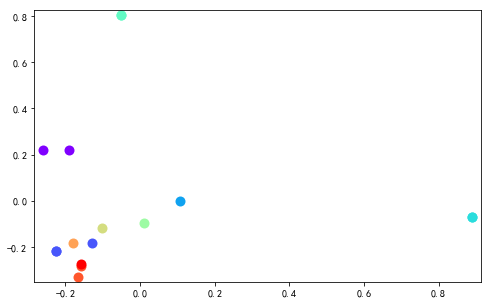

丽发 新城 小区 搅拌站 噪音 扰民
投诉 丽发 新城 小区 违建 搅拌站 噪音 扰民
丽发 新城 小区 旁边 建 搅拌站
丽发 新城 小区 建 搅拌站
丽发 新城 小区 搅拌站
昏天暗地 噪声 丽发 新城 小区 A2区
希望 领导 拯救 丽发 新城 小区 居民
希望 领导 拯救 丽发 新城 小区 居民
丽发 新城 小区 旁建 搅拌 厂 扰民
丽发 新城 小区 旁建 搅拌 厂 扰民
==================================大学荷塘小区==============================


In [173]:
for place in places:
    print("==================================%s=============================="%place)
    region=(test[test['地区']==place])
    if(len(region)==1):
        break
    tfidf_matrix,corpus,num=cluster(region)
    res=train_kmeans(num,tfidf_matrix,corpus)